# IN - Analysis Notebook - post - processing EDA

In [0]:
from pyspark.sql.functions import col, udf, expr
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np
from pyspark.sql import Window
from pyspark.sql.functions import date_add, to_timestamp
from pyspark.sql.functions import col, unix_timestamp, from_unixtime
import pandas as pd

print("Welcome to the W261 final project!")

Welcome to the W261 final project!


# Connect to team storage blob

In [0]:
# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "team-3-2-project261"       # The name of your container created in https://portal.azure.com
storage_account = "fall2024team32"  # The name of your Storage account created in https://portal.azure.com
secret_scope    = "scope_team_3_2"           # The name of the scope created in your local computer using the Databricks CLI
secret_key      = "key_team_3_2"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url   = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket


# the 261 course blob storage is mounted here.
mids261_mount_path      = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# IN check the listing in team blob
display(dbutils.fs.ls(f"{team_blob_url}"))

path,name,size,modificationTime
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_cancelled_data/,12m_cancelled_data/,0,1731754303000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_diverted_data/,12m_diverted_data/,0,1731754311000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_duplicates_removed/,12m_duplicates_removed/,0,1733298522000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data/,12m_final_data/,0,1731755226000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data_deduped/,12m_final_data_deduped/,0,1731805979000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_destination/,12m_mean_year_month_destination/,0,1731754740000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_origin/,12m_mean_year_month_origin/,0,1731754736000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_null_summary/,12m_null_summary/,0,1731754630000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_sorted_data/,12m_sorted_data/,0,1731754292000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_summary_statistics/,12m_summary_statistics/,0,1731756196000



# Know your mount
Here is the mounting for this class, your source for the original data! Remember, you only have Read access, not Write! Also, become familiar with `dbutils` the equivalent of `gcp` in DataProc

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/2014_flights/,2014_flights/,0,1731598242000
dbfs:/mnt/mids-w261/HW5/,HW5/,0,0
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,1721794777000
dbfs:/mnt/mids-w261/OTPW_12M_2015.parquet/,OTPW_12M_2015.parquet/,0,1721930011000
dbfs:/mnt/mids-w261/OTPW_12M_2015_cleaned_sorted.parquet/,OTPW_12M_2015_cleaned_sorted.parquet/,0,1731788138000
dbfs:/mnt/mids-w261/OTPW_12M_2015_sorted.parquet/,OTPW_12M_2015_sorted.parquet/,0,1731652365000
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,0
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,1721832995000
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1679772070000


In [0]:
dbutils.fs.help()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

# Post-processing EDA analysis

In [0]:
# Data import from data processing
# data_col_cleaned = (spark.read.parquet(f"{team_blob_url}/clean_data_3m_parquet/"))
# data_col_cleaned = (spark.read.parquet(f"{team_blob_url}/12m_final_data/"))
# data_col_cleaned = (spark.read.parquet(f"{team_blob_url}/12m_final_data_deduped/"))
# data_col_cleaned = (spark.read.parquet(f"{team_blob_url}/12m_take_2_final_data/"))
# data_col_cleaned_12m = (spark.read.parquet(f"{team_blob_url}/12m_take_5_final/"))
data_col_cleaned = (spark.read.parquet(f"{team_blob_url}/60m_take_4_final//"))

null_summary = (spark.read.parquet(f"{team_blob_url}/60m_take_4_null_summary/"))

stats_summary_num = (spark.read.parquet(f"{team_blob_url}/60m_take_4_summary_statistics/"))

spearman_corr_df = (spark.read.parquet(f"{team_blob_url}/60m_take_4_spearman_corr/"))

In [0]:
# reset the datatype for cleaned data 


In [0]:
data_col_cleaned.count()

31099553

In [0]:
display(data_col_cleaned.dtypes)

_1,_2
QUARTER,int
DAY_OF_MONTH,int
DAY_OF_WEEK,int
FL_DATE,date
OP_UNIQUE_CARRIER,string
OP_CARRIER_AIRLINE_ID,int
OP_CARRIER,string
TAIL_NUM,string
OP_CARRIER_FL_NUM,int
ORIGIN_AIRPORT_ID,int


##Null value analysis based on Rahul's null summary

In [0]:
display(null_summary)

column_name,total_nulls,percentage_nulls,status
DailyDepartureFromNormalAverageTemperature,31618781,99.82844127223467,Drop this column
DailyHeatingDegreeDays,31615712,99.81875166762073,Drop this column
DailyMaximumDryBulbTemperature,31615710,99.81874535311789,Drop this column
DailyMinimumDryBulbTemperature,31615708,99.81873903861505,Drop this column
DailyPeakWindDirection,31616003,99.81967042778453,Drop this column
DailyPeakWindSpeed,31615903,99.81935470264233,Drop this column
DailyPrecipitation,31615648,99.81854960352973,Drop this column
DailySnowDepth,31638104,99.88944884146079,Drop this column
DailySnowfall,31637211,99.886629415941,Drop this column
DailySustainedWindDirection,31615649,99.81855276078116,Drop this column


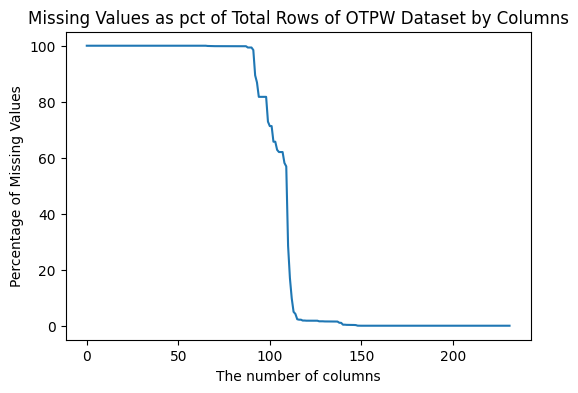

There are 150 columns which have missing values.
There are 66 columns which miss value for all obervations.
91 columns miss values for more than 99% of observations.
20 columns miss values for more than 20% and less than 99% of observations.
121 columns miss values for less than or equal to 20% of observations.


In [0]:
otpw_null_counts_pd_rh = null_summary.select(col('column_name'), col('percentage_nulls')).toPandas().sort_values(by='percentage_nulls', ascending=False)
# otpw_null_counts_pd_rh

plt.figure(figsize=(6, 4)) 
(otpw_null_counts_pd_rh).reset_index()['percentage_nulls'].plot(
    title='Missing Values as pct of Total Rows of OTPW Dataset by Columns'
)
plt.xlabel('The number of columns')
plt.ylabel('Percentage of Missing Values')
plt.show()

tot_count_missing_val_rh = otpw_null_counts_pd_rh.loc[otpw_null_counts_pd_rh['percentage_nulls']>0].count()[0]
print (f'There are {tot_count_missing_val_rh} columns which have missing values.')
num_max_missing_val_rh = (otpw_null_counts_pd_rh[otpw_null_counts_pd_rh['percentage_nulls']==100]).count()[0]
print (f'There are {num_max_missing_val_rh} columns which miss value for all obervations.')
num_missing_val_gt_99_rh = (otpw_null_counts_pd_rh[otpw_null_counts_pd_rh['percentage_nulls']>99]).count()[0]
print (f'{num_missing_val_gt_99_rh} columns miss values for more than 99% of observations.')
num_missing_val_gt_20_lt_99_rh = (otpw_null_counts_pd_rh[(otpw_null_counts_pd_rh['percentage_nulls']<=99)
                                                   &(otpw_null_counts_pd_rh['percentage_nulls']>20)]).count()[0]
print (f'{num_missing_val_gt_20_lt_99_rh} columns miss values for more than 20% and less than 99% of observations.')
num_missing_val_lt_20_rh = (otpw_null_counts_pd_rh[otpw_null_counts_pd_rh['percentage_nulls']<=20]).count()[0]
print (f'{num_missing_val_lt_20_rh} columns miss values for less than or equal to 20% of observations.')

## More analysis based on Rahul's data with dropped columns (per null %)

In [0]:
(data_col_cleaned).count()

31099553

In [0]:
# columns_list2 = data_dropped_cols_3m.columns
print(f'The dimension of the data is {data_col_cleaned.count()} rows and {len(data_col_cleaned.columns)} columns.')
# schema_df2 = spark.createDataFrame(data_col_cleaned.dtypes, ["Column Name", "Data Type"])
# display(schema_df2)

The dimension of the data is 31099553 rows and 119 columns.


In [0]:
display(data_col_cleaned.dtypes)

_1,_2
QUARTER,int
DAY_OF_MONTH,int
DAY_OF_WEEK,int
FL_DATE,date
OP_UNIQUE_CARRIER,string
OP_CARRIER_AIRLINE_ID,int
OP_CARRIER,string
TAIL_NUM,string
OP_CARRIER_FL_NUM,int
ORIGIN_AIRPORT_ID,int


In [0]:
# plot overall label distribution
dep_g_count_pd = data_col_cleaned.groupBy(['DEP_DELAY_GROUP']).agg(F.count('FLIGHTS').alias('Counts_by_Delay_Group')).toPandas()
dep_g_count_pd['DEP_DELAY_GROUP'] = dep_g_count_pd['DEP_DELAY_GROUP'].astype(int)
dep_g_count_pd['Counts_by_Delay_Group'] = dep_g_count_pd['Counts_by_Delay_Group'].astype(float)

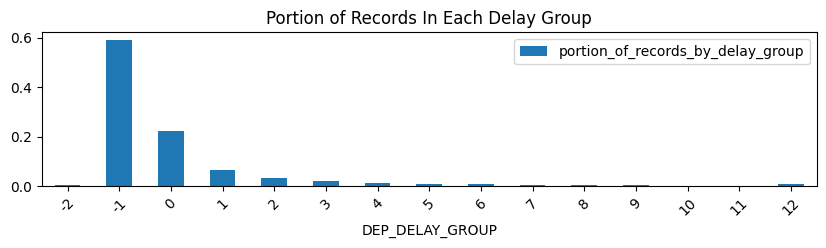

In [0]:
(dep_g_count_pd.groupby('DEP_DELAY_GROUP')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd['Counts_by_Delay_Group'].sum()).rename('portion_of_records_by_delay_group')\
        .to_frame().plot(kind='bar', figsize=(10, 2))
plt.title('Portion of Records In Each Delay Group')
plt.xticks(rotation=45)
plt.show()

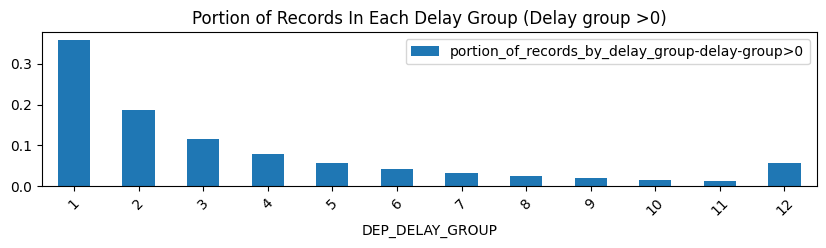

In [0]:
(dep_g_count_pd[dep_g_count_pd['DEP_DELAY_GROUP']>0].groupby('DEP_DELAY_GROUP')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd[dep_g_count_pd['DEP_DELAY_GROUP']>0]['Counts_by_Delay_Group'].sum()).rename('portion_of_records_by_delay_group-delay-group>0')\
        .to_frame().plot(kind='bar', figsize=(10, 2))
plt.title('Portion of Records In Each Delay Group (Delay group >0)')
plt.xticks(rotation=45)
plt.show()

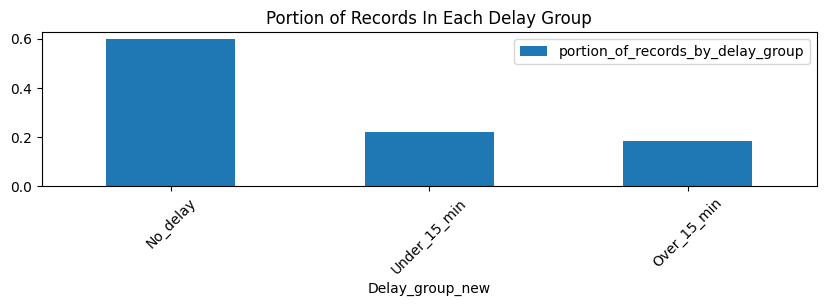

In [0]:
dep_g_count_pd['Delay_group_new'] = dep_g_count_pd['DEP_DELAY_GROUP'].apply(lambda x: 'No_delay' if x <0 
                                                                            else ('Under_15_min' if x==0
                                                                            else 'Over_15_min'))

(dep_g_count_pd.groupby('Delay_group_new')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd['Counts_by_Delay_Group'].sum()).rename('portion_of_records_by_delay_group')\
        .to_frame().reindex(['No_delay','Under_15_min','Over_15_min']).plot(kind='bar', figsize=(10, 2))
plt.title('Portion of Records In Each Delay Group')
plt.xticks(rotation=45)
plt.show()

In [0]:
print('The proportion of delay groups with new grouping:')
(dep_g_count_pd.groupby('Delay_group_new')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd['Counts_by_Delay_Group'].sum()).rename('portion_of_records_by_delay_group')\
        .to_frame().reindex(['No_delay','Under_15_min','Over_15_min'])

The proportion of delay groups with new grouping:


,portion_of_records_by_delay_group
Delay_group_new,
No_delay,0.597053
Under_15_min,0.221550
Over_15_min,0.181397


In [0]:
print('The proportion of delay groups within the groups which are delayed (delay mins >0min):')
(dep_g_count_pd[dep_g_count_pd['DEP_DELAY_GROUP']>=0].groupby('Delay_group_new')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd[dep_g_count_pd['DEP_DELAY_GROUP']>=0]['Counts_by_Delay_Group'].sum())

The proportion of delay groups within the groups which are delayed (delay mins >0min):


Delay_group_new
Over_15_min     0.450176
Under_15_min    0.549824
Name: Counts_by_Delay_Group, dtype: float64

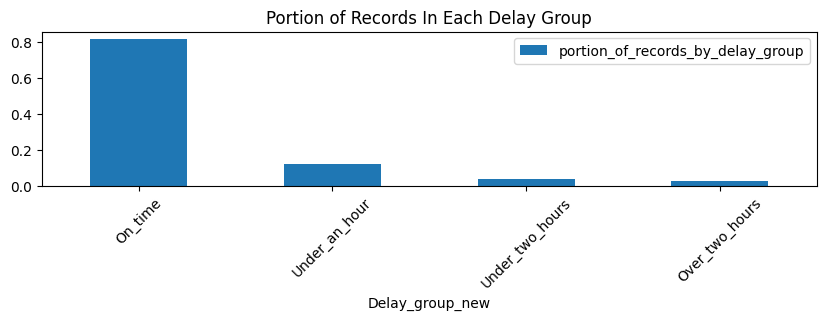

In [0]:
# phase I proposal of label distribution
dep_g_count_pd['Delay_group_new'] = dep_g_count_pd['DEP_DELAY_GROUP'].apply(lambda x: 'On_time' if x <=0 
                                                                            else ('Under_an_hour' if x<4
                                                                            else ('Under_two_hours' if x<8
                                                                            else ('Over_two_hours'))))


(dep_g_count_pd.groupby('Delay_group_new')['Counts_by_Delay_Group'].sum()\
    /dep_g_count_pd['Counts_by_Delay_Group'].sum()).rename('portion_of_records_by_delay_group')\
        .to_frame().reindex(['On_time','Under_an_hour','Under_two_hours','Over_two_hours']).plot(kind='bar', figsize=(10, 2))
plt.title('Portion of Records In Each Delay Group')
plt.xticks(rotation=45)
plt.show()

## We need to clearly distinguish the treatment of numerical variables and categorical variables (in broad sense, including ordinal, interval and nominal measurements)

In [0]:
num_cols = ['DEP_DELAY_NEW',
	'TAXI_OUT',
	'TAXI_IN',
	'ARR_DELAY_NEW',
	'CRS_ELAPSED_TIME',
	'ACTUAL_ELAPSED_TIME',
	'AIR_TIME',
	'DISTANCE',
	'ELEVATION',
	'HourlyAltimeterSetting',
	'HourlyDewPointTemperature', #IN highly correlated with HourlyDryBulbTemperature
	'HourlyDryBulbTemperature',
	'HourlyPrecipitation',
	'HourlyRelativeHumidity',
	'HourlySeaLevelPressure',
	'HourlyStationPressure',
	'HourlyVisibility',
	'HourlyWetBulbTemperature', #IN highly correlated with HourlyDryBulbTemperature
 	'HourlyWindDirection', #IN why is this not included?
	'HourlyWindSpeed']

tgt_var = ['DEP_DELAY_GROUP'] #'DEP_DELAY_GROUP' will be regrouped later
key_id_features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST','OP_CARRIER_FL_NUM']
key_time_features = ['two_hours_prior_depart_UTC', 'sched_depart_date_time', 'sched_depart_date_time_UTC', 'four_hours_prior_depart_UTC','FL_DATE']
#: note that other columns are categorical variables (nominal, interval or ordinal in nature)

In [0]:
# IN temp - check if we haven't discussed certain cols
# cols_not_yet_discussed = 
# [row.column_name for row in self.null_summary_df.filter(col("status") == status).collect()]
# cols_not_yet_discussed = ([col_name for col_name, col_dtype in data_dropped_cols_3m.dtypes if col_dtype in ['bigint','date','string','timestamp']])
# cols_not_yet_discussed =([col_name for col_name, col_dtype in data_col_cleaned.dtypes if col_dtype not in ["double", "int", "float", "long"]])
# display(data_dropped_cols_3m.select(*cols_not_yet_discussed))

## EDA for key numerical variables

In [0]:
num_variables_pd = data_col_cleaned.select(*num_cols).toPandas()

# Boxplot in pandas (wont work for data beyond 3m)
# plt.figure(figsize=(15, 5))
# num_variables_pd.boxplot(column=num_cols)
# plt.title('Boxplots of Numerical Variables')
# plt.xlabel('Numerical Variables')
# plt.ylabel('Values')
# plt.xticks(rotation=45)
# plt.show()

In [0]:
## Change to use Stats table to present numerical variables results
# stats_summary_num_pd = (spark.read.parquet(f"{team_blob_url}/12m_summary_statistics/")).toPandas()
# stats_summary_num_pd = (spark.read.parquet(f"{team_blob_url}/12m_take_2_summary_statistics/")).toPandas()
stats_summary_num_pd = stats_summary_num.toPandas()
stats_summary_num_pd

,column_name,data_type,total_nulls,percentage_nulls,mean,stddev,Q0,Q1,Q2,Q3,Q4,IQR
0,HourlyDewPointTemperature,double,0,0.000000,47.591309,18.536089,-47.000000,34.000000,50.000000,63.000000,95.000000,29.000000
1,HourlyWetBulbTemperature,double,0,0.000000,55.257064,15.743000,-38.000000,45.000000,57.081209,68.000000,98.000000,23.000000
2,HourlyDryBulbTemperature,double,0,0.000000,63.973348,18.690620,-51.000000,52.000000,66.000000,78.000000,125.000000,26.000000
3,HourlyAltimeterSetting,double,0,0.000000,30.028472,0.184363,28.170000,29.920000,30.020000,30.136341,31.090000,0.216341
4,HourlySeaLevelPressure,double,0,0.000000,30.020359,0.190259,28.370001,29.910000,30.015558,30.129999,31.299999,0.219999
5,HourlyRelativeHumidity,double,0,0.000000,60.404676,21.629885,1.000000,45.000000,62.000000,77.000000,100.000000,32.000000
6,HourlyStationPressure,double,0,0.000000,29.150839,1.319706,19.790001,29.049999,29.500000,29.920000,31.020000,0.870001
7,ACTUAL_ELAPSED_TIME,double,1,0.000003,138.147667,74.306948,14.000000,84.000000,119.000000,169.000000,1604.000000,85.000000
8,HourlyPrecipitation,double,0,0.000000,0.003613,0.027402,0.000000,0.000000,0.000000,0.000000,5.760000,0.000000
9,HourlyVisibility,double,0,0.000000,9.446662,1.823301,0.000000,10.000000,10.000000,10.000000,99.419998,0.000000


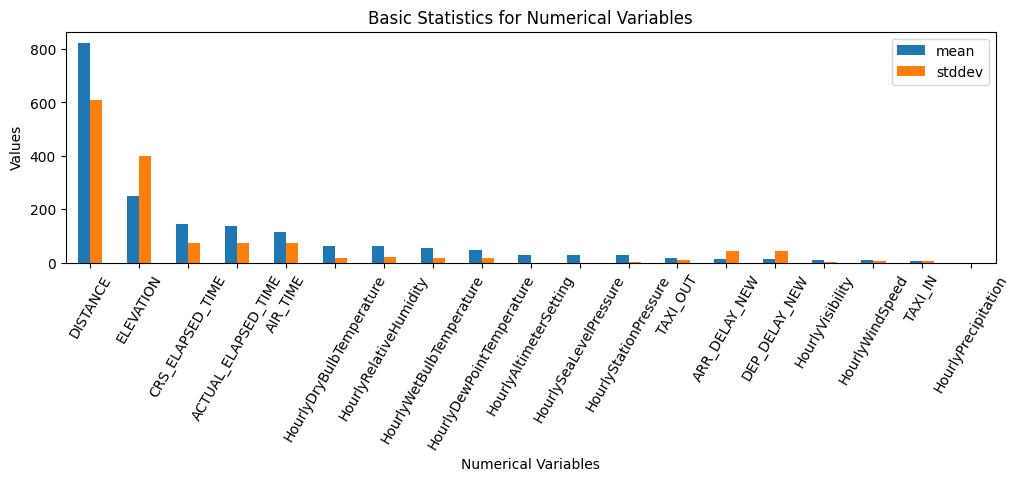

In [0]:
# # plt.figure(figsize=(10,2))
# ca_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Unique Carriers')
# # plt.xticks(rotation=45)
# plt.show()

stats_summary_num_pd[['column_name','mean','stddev']]\
.set_index('column_name').sort_values(by='mean', ascending=False)\
    .plot(figsize=(12, 3), kind='bar')
plt.title('Basic Statistics for Numerical Variables')
plt.xlabel('Numerical Variables')
plt.ylabel('Values')
plt.xticks(rotation=60)
plt.show()

In [0]:
# spearman_corr_rc_3m = (spark.read.parquet(f"{team_blob_url}/spearman_corr_3m_parquet/"))
# spearman_corr_df = (spark.read.parquet(f"{team_blob_url}/12m_take_2_spearman_corr/"))
display(spearman_corr_df)

TargetColumn,NumericColumn,Spearman_Correlation
DEP_DELAY_GROUP,HourlyDewPointTemperature,0.03769228492741654
DEP_DELAY_GROUP,HourlyDryBulbTemperature,0.003999161816640014
DEP_DELAY_GROUP,HourlyWetBulbTemperature,0.026095945819087484
DEP_DELAY_GROUP,HourlyAltimeterSetting,-0.0558404752560904
DEP_DELAY_GROUP,HourlySeaLevelPressure,-0.04564981180896516
DEP_DELAY_GROUP,HourlyRelativeHumidity,0.062132141201066964
DEP_DELAY_GROUP,HourlyStationPressure,-0.004246741357103862
DEP_DELAY_GROUP,HourlyPrecipitation,0.05508215148840249
DEP_DELAY_GROUP,ACTUAL_ELAPSED_TIME,0.03852104008155313
DEP_DELAY_GROUP,HourlyVisibility,-0.03733040345839048


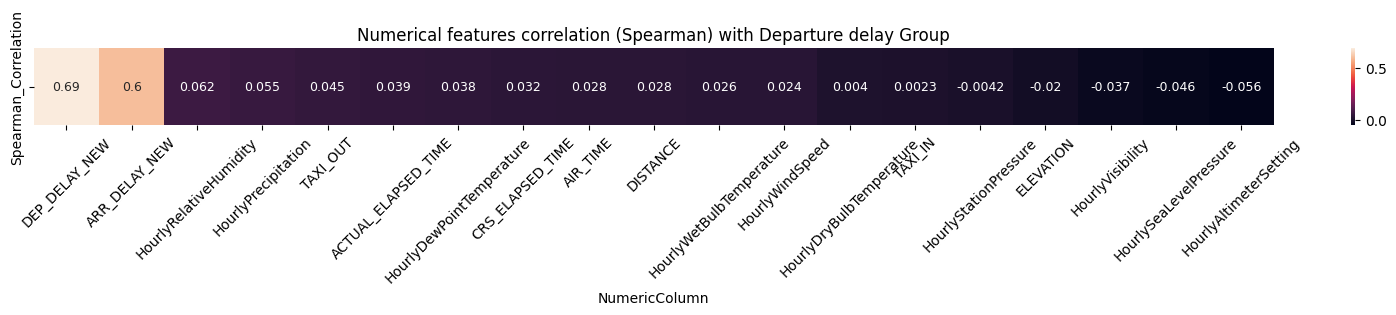

In [0]:
# IN visualization of spearman correlation
spearman_corr_pd = spearman_corr_df.toPandas()
spearman_corr_pd = spearman_corr_pd[['NumericColumn','Spearman_Correlation']]\
    .set_index('NumericColumn').sort_values(by='Spearman_Correlation', ascending=False)

plt.figure(figsize=(20,1))
hm = sns.heatmap(spearman_corr_pd.T, annot=True, annot_kws={'size':9})
plt.title('Numerical features correlation (Spearman) with Departure delay Group')
plt.xticks(rotation=45)
plt.show()

In [0]:
## Selective numerical variable's boxplot by Departure Delay Group (bigger groups)

def selective_num_boxplot(input_df, tgt_col, num_col_focus, ylim=False):
    input_df = data_col_cleaned

    df_no_delay = input_df.filter(F.col(tgt_col)<0).select(num_col_focus).toPandas()
    df_lt_15min_delay = input_df.filter(F.col(tgt_col)==0).select(num_col_focus).toPandas()
    df_gt_15min_delay = input_df.filter(F.col(tgt_col)>0).select(num_col_focus).toPandas()

    # plt.figure(figsize=(8,3))
    # plt.hist(df_no_delay[num_col_focus], bins=20, color='blue', alpha=0.2, label='No Delay')
    # plt.hist(df_lt_15min_delay[num_col_focus], bins=20, color='yellow', alpha=0.2, label='Less_than_15_min_delay')
    # plt.hist(df_gt_15min_delay[num_col_focus], bins=20, color='red', alpha=0.2, label='More_then_15_min_delay')
    # plt.title(f'Histogram of {num_col_focus} by Departure Delay Group')
    # plt.xlabel('{num_col_focus}')
    # plt.ylabel('Count')
    # plt.legend(loc='upper right')
    # plt.show()

    boxplot_df = pd.concat([
        df_no_delay.assign(Delay_group ="No_delay"),
        df_lt_15min_delay.assign(Delay_group="Less_than_15min_delay"),
        df_gt_15min_delay.assign(Delay_group="More_than_15min_delay")
    ])

    plt.figure(figsize=(8,3))
    sns.boxplot(data=boxplot_df, x='Delay_group', y=num_col_focus, palette='Set2', hue='Delay_group')
    plt.title(f'Boxplot of {num_col_focus} by Departure Delay Group')
    plt.xlabel('Delay_group')
    plt.ylabel(f'{num_col_focus}')
    if ylim:    
        plt.ylim(boxplot_df[num_col_focus].quantile(0.01), boxplot_df[num_col_focus].quantile(0.99))
    plt.show()

    return boxplot_df

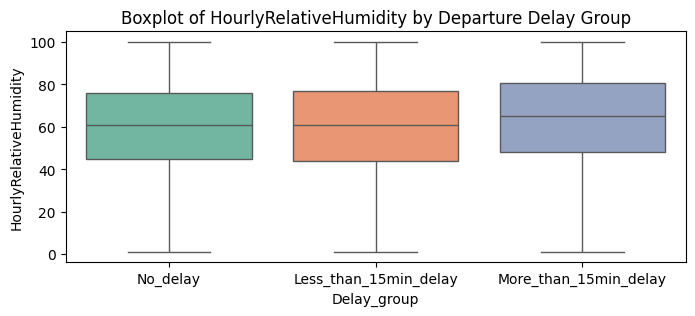

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyRelativeHumidity'

boxplot_df_humidity = selective_num_boxplot(input_df, tgt_col, num_col_focus)

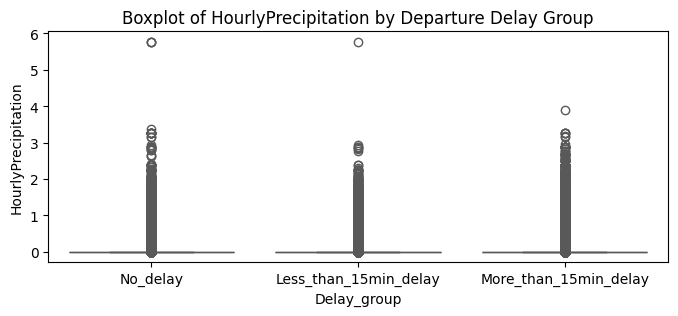

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyPrecipitation'

boxplot_df_precipitation = selective_num_boxplot(input_df, tgt_col, num_col_focus)

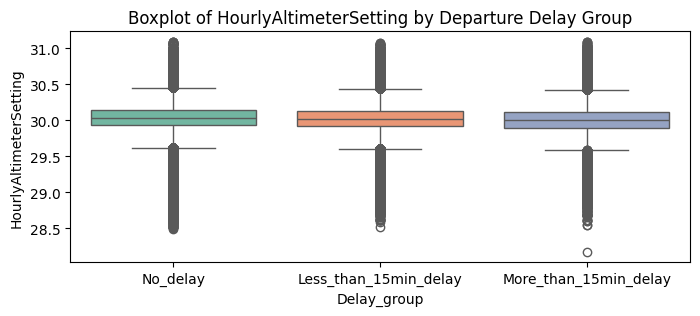

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyAltimeterSetting'

boxplot_df_altimeterSetting = selective_num_boxplot(input_df, tgt_col, num_col_focus)

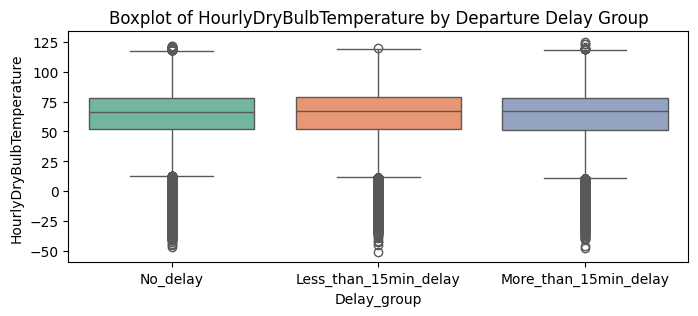

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyDryBulbTemperature'

boxplot_df_drytemp = selective_num_boxplot(input_df, tgt_col, num_col_focus)

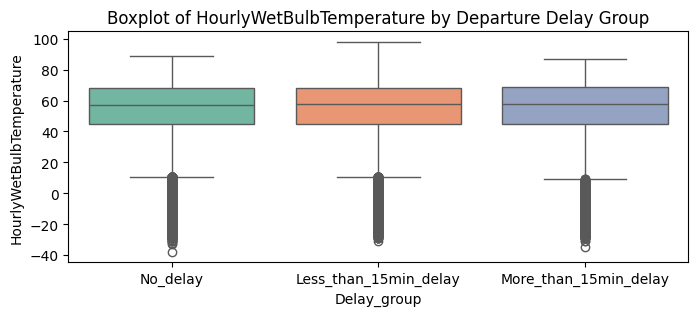

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyWetBulbTemperature'

boxplot_df_wettemp = selective_num_boxplot(input_df, tgt_col, num_col_focus)

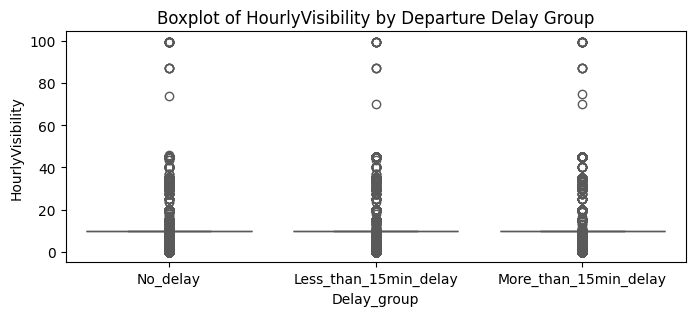

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='HourlyVisibility'

boxplot_df_visibility = selective_num_boxplot(input_df, tgt_col, num_col_focus)

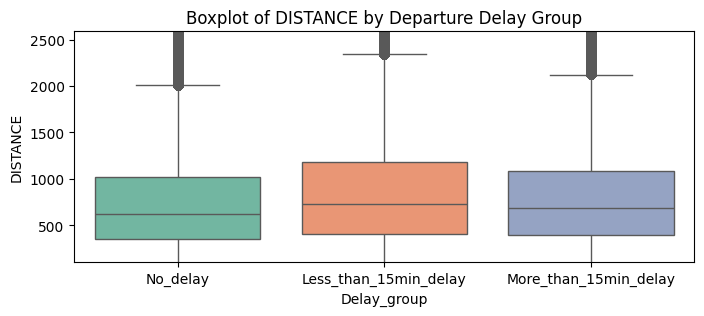

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='DISTANCE'

boxplot_df_distance = selective_num_boxplot(input_df, tgt_col, num_col_focus, ylim=True)

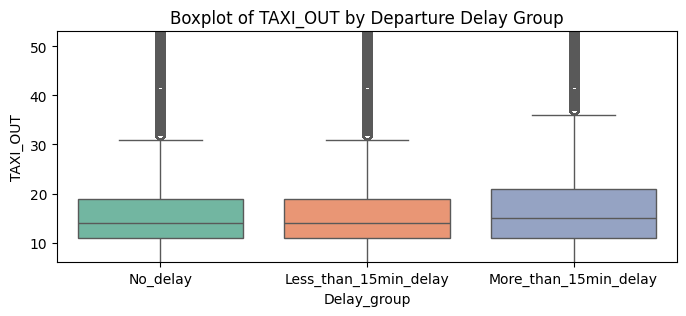

In [0]:
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='TAXI_OUT'

boxplot_df_taxi_out = selective_num_boxplot(input_df, tgt_col, num_col_focus, ylim=True)

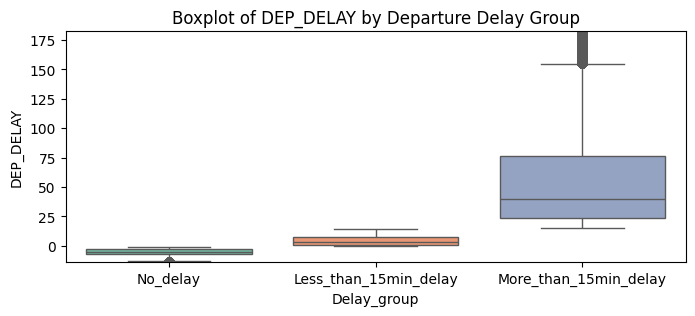

In [0]:
# IN: not directly for feature just for reference
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='DEP_DELAY'

boxplot_df_dep_delay = selective_num_boxplot(input_df, tgt_col, num_col_focus, ylim=True)

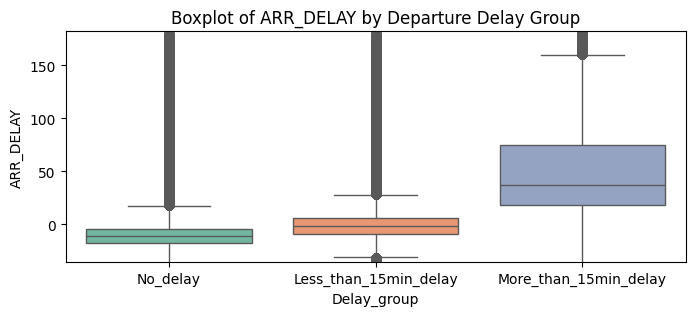

In [0]:
# IN: not directly for feature just for reference
input_df = data_col_cleaned
tgt_col = 'DEP_DELAY_GROUP'
num_col_focus ='ARR_DELAY'

boxplot_df_arr_delay = selective_num_boxplot(input_df, tgt_col, num_col_focus, ylim=True)

## EDA on selected categorical variables

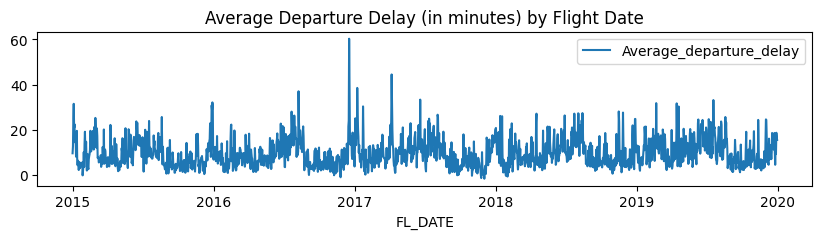

In [0]:
# IN look at a few categorical variables' variability in terms of departure delay (using minutes for visualization)
# Check if there is any obvious time trend
ts_delay_pd = (data_col_cleaned.groupby(['FL_DATE']).agg(F.avg('DEP_DELAY').alias('Average_departure_delay'))).toPandas()
ts_delay_pd = ts_delay_pd.set_index('FL_DATE').sort_index()

# plt.figure(figsize=(10,2))
ts_delay_pd.plot(kind='line', figsize=(10, 2))
plt.title('Average Departure Delay (in minutes) by Flight Date')
# plt.xticks(rotation=45)
plt.show()

In [0]:
## plotting helper functions
# avg delay time
def get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, sort_values=False, ascending=False, figsize=(10,5)):
    df_pandas = (input_df.groupby([groupby_col]).agg(F.avg(tgt_num_col).alias(f'Average_{tgt_num_col}'))).toPandas()
    df_pandas = df_pandas.set_index(groupby_col)

    if sort_index:
        df_pandas = df_pandas.sort_index()
    elif sort_values:
        df_pandas = df_pandas.sort_values(f'Average_{tgt_num_col}', ascending=ascending)

    # plt.figure(figsize=(10,2))
    df_pandas.plot(kind='bar', figsize=figsize)
    plt.title(f'Average {tgt_num_col} (in minutes) by {groupby_col}')
    # plt.xticks(rotation=45)
    plt.show()

    return df_pandas


# percentage by tgt label
def get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True, sort_values=False, ascending=False, figsize=(10,5), xticker_rotate=False):

    df_counts = input_df.groupBy(groupby_col).agg(
        F.sum(F.when(F.col(tgt_col) < 0, 1).otherwise(0)).alias("count_no_delay"),
        F.sum(F.when(F.col(tgt_col) == 0, 1).otherwise(0)).alias("count_delay_lt_15min"),
        F.sum(F.when(F.col(tgt_col) > 0, 1).otherwise(0)).alias("count_delay_gt_15min"),
        F.count("FL_DATE").alias("total_count")
    )

    # Calculate percentages for each condition
    df_percentages = df_counts.withColumn("pct_no_delay", F.col("count_no_delay") / F.col("total_count")) \
                            .withColumn("pct_delay_lt_15min", F.col("count_delay_lt_15min") / F.col("total_count")) \
                            .withColumn("pct_delay_gt_15min", F.col("count_delay_gt_15min") / F.col("total_count")).select(groupby_col, "pct_no_delay", "pct_delay_lt_15min", "pct_delay_gt_15min")

    df_pandas = df_percentages.toPandas().set_index(groupby_col)

    if sort_index:
        df_pandas = df_pandas.sort_index()
    elif sort_values:
        df_pandas = df_pandas.sort_values('pct_delay_gt_15min', ascending=ascending)

    df_pandas.plot(kind='bar', stacked=True, color=["#1a9850","#fdae61", "#d73027"], figsize=figsize).legend(bbox_to_anchor=(1,1))
    plt.title(f'Percentage of Flights Departure Delay by {groupby_col}')
    plt.ylabel('Percentage-of-delay-label')
    if xticker_rotate:
        plt.xticks(rotation=45)
    plt.show()

    return df_pandas 

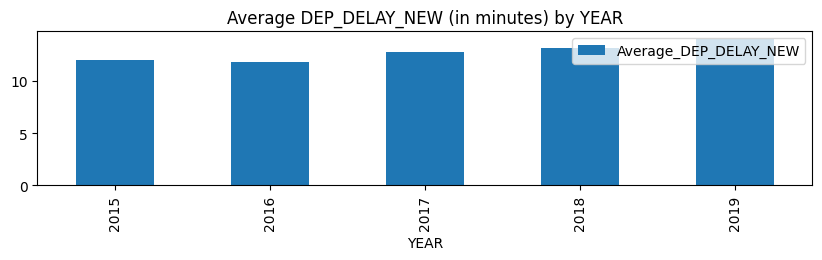

In [0]:
# By Year
input_df = data_col_cleaned
groupby_col = 'YEAR'
tgt_num_col = 'DEP_DELAY_NEW'
yr_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

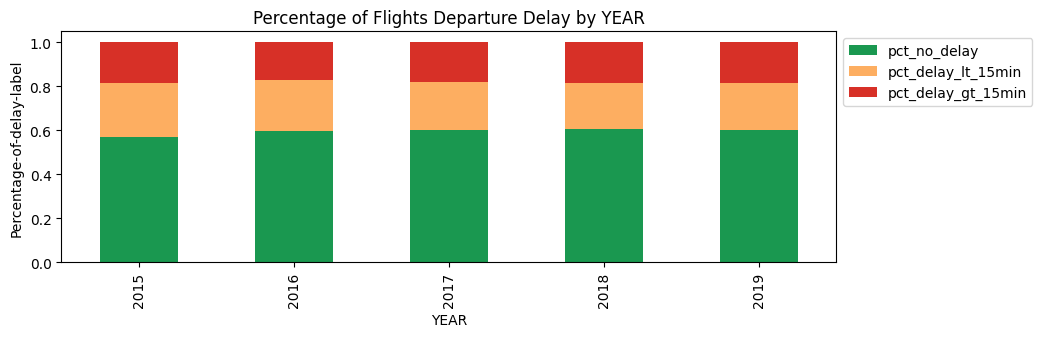

In [0]:
input_df = data_col_cleaned
groupby_col = 'YEAR'
tgt_col = 'DEP_DELAY_GROUP'

yr_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True, figsize=(10,3))

In [0]:
yr_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
YEAR,,,
2015,0.572428,0.243833,0.183740
2016,0.599045,0.229876,0.171080
2017,0.601689,0.217855,0.180455
2018,0.605892,0.210632,0.183476
2019,0.602763,0.211112,0.186125


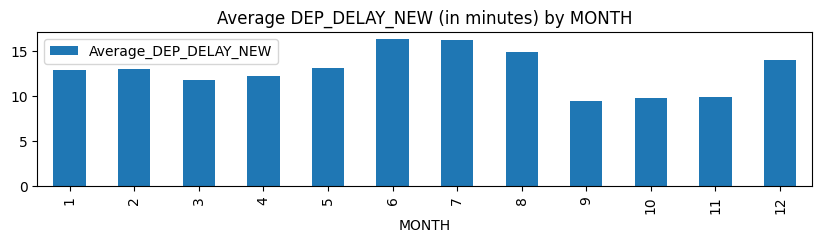

In [0]:
# Check if there is any pattern on year level (will be useless for any data within a year)
# yr_delay_pd = (data_col_cleaned.groupby(['YEAR']).agg(F.avg('DEP_DELAY').alias('Average_departure_delay'))).toPandas()
# yr_delay_pd = yr_delay_pd.set_index('YEAR').sort_index()

# # plt.figure(figsize=(10,2))
# yr_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Flight Year')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'MONTH'
tgt_num_col = 'DEP_DELAY_NEW'
month_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

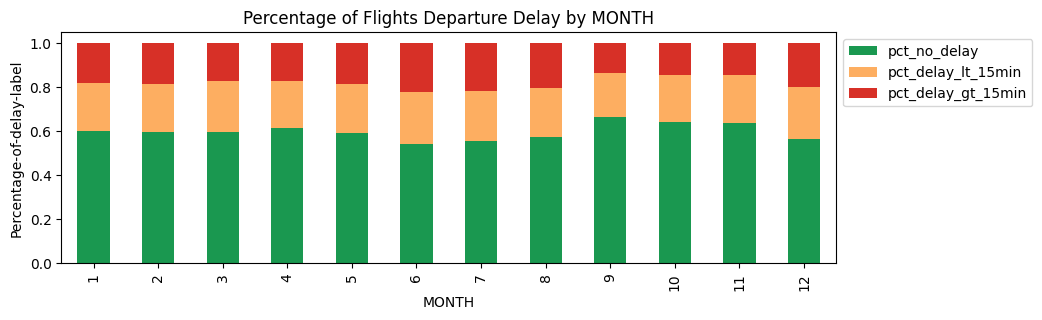

In [0]:
# Year - percentage of flights departure delay

input_df = data_col_cleaned
groupby_col = 'MONTH'
tgt_col = 'DEP_DELAY_GROUP'

month_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True, figsize=(10,3))

In [0]:
month_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
MONTH,,,
1,0.598105,0.217958,0.183937
2,0.596281,0.218857,0.184862
3,0.596620,0.228905,0.174474
4,0.615117,0.213865,0.171018
5,0.591697,0.222558,0.185745
6,0.541733,0.234583,0.223684
7,0.555602,0.227135,0.217264
8,0.574519,0.221217,0.204265
9,0.665041,0.197969,0.136990


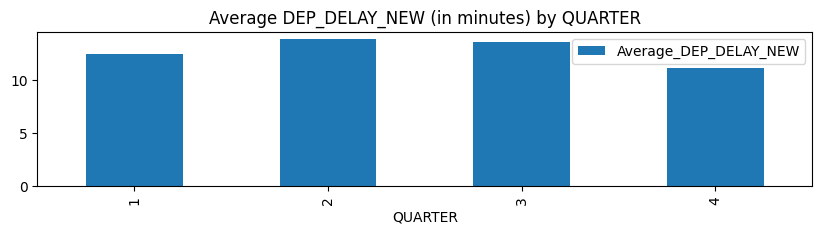

In [0]:
# Check if there is any pattern on quarter level (will be useless for any data within a quarter)
# qr_delay_pd = (data_col_cleaned.groupby(['QUARTER']).agg(F.avg('DEP_DELAY').alias('Average_departure_delay'))).toPandas()
# qr_delay_pd = qr_delay_pd.set_index('QUARTER').sort_index()

# # plt.figure(figsize=(10,2))
# qr_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Flight QUARTER')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'QUARTER'
tgt_num_col = 'DEP_DELAY_NEW'
qr_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

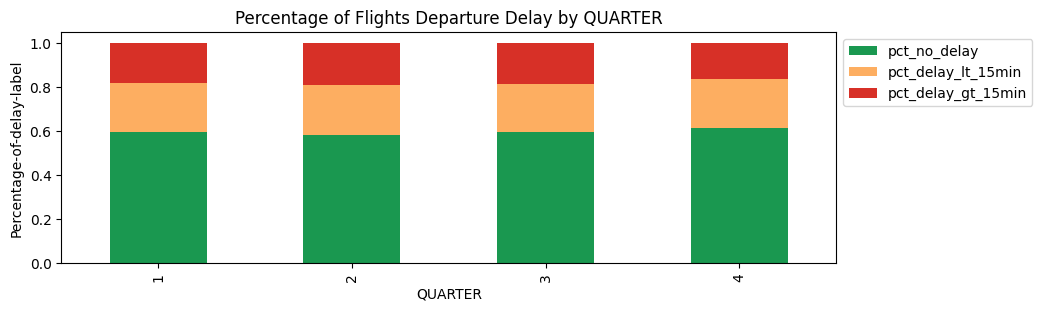

In [0]:
# Quarter of the year - percentage of flights departure delay
input_df = data_col_cleaned
groupby_col = 'QUARTER'
tgt_col = 'DEP_DELAY_GROUP'

qr_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True,  figsize=(10,3))

In [0]:
qr_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
QUARTER,,,
1,0.597010,0.222186,0.180804
2,0.582363,0.223812,0.193824
3,0.596351,0.215975,0.187674
4,0.612879,0.224433,0.162688


Comments: this metrics is useless for any data within a quarter

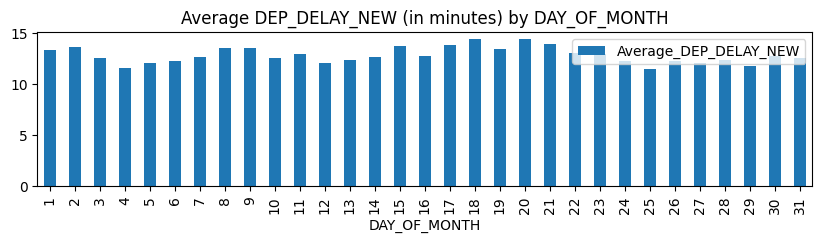

In [0]:
# Day of month - AVG DEP DELAY TIME
# md_delay_pd = (data_col_cleaned.groupby(['DAY_OF_MONTH']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# md_delay_pd = md_delay_pd.set_index('DAY_OF_MONTH').sort_index()

# # plt.figure(figsize=(10,2))
# md_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Day of Month')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'DAY_OF_MONTH'
tgt_num_col = 'DEP_DELAY_NEW'
md_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

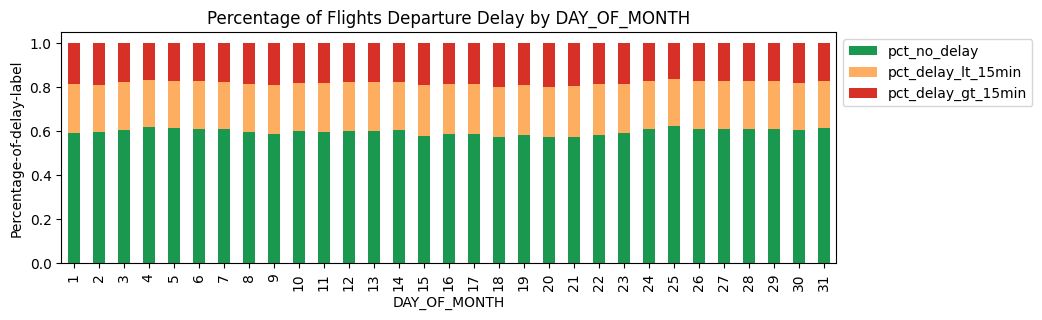

In [0]:
# Day of month - percentage of flights departure delay

input_df = data_col_cleaned
groupby_col = 'DAY_OF_MONTH'
tgt_col = 'DEP_DELAY_GROUP'

md_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True,  figsize=(10,3))

In [0]:
md_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
DAY_OF_MONTH,,,
1,0.588894,0.223159,0.187947
2,0.593511,0.216628,0.189861
3,0.605330,0.216070,0.178600
4,0.618708,0.214235,0.167057
5,0.612275,0.215001,0.172724
6,0.611092,0.214652,0.174256
7,0.607467,0.215918,0.176615
8,0.594696,0.220166,0.185138
9,0.587672,0.222257,0.190071


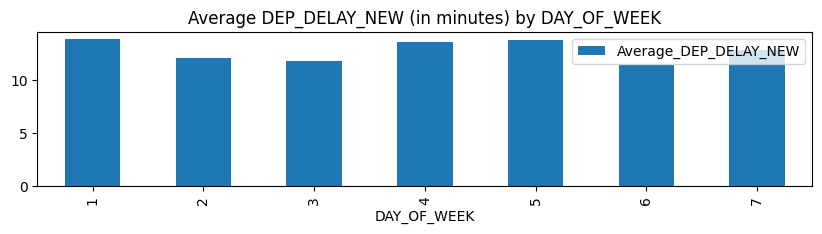

In [0]:
# Day of week
# wd_delay_pd = (data_col_cleaned.groupby(['DAY_OF_WEEK']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# wd_delay_pd = wd_delay_pd.set_index('DAY_OF_WEEK').sort_index()

# # plt.figure(figsize=(10,2))
# wd_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Day of Week')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'DAY_OF_WEEK'
tgt_num_col = 'DEP_DELAY_NEW'
wd_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

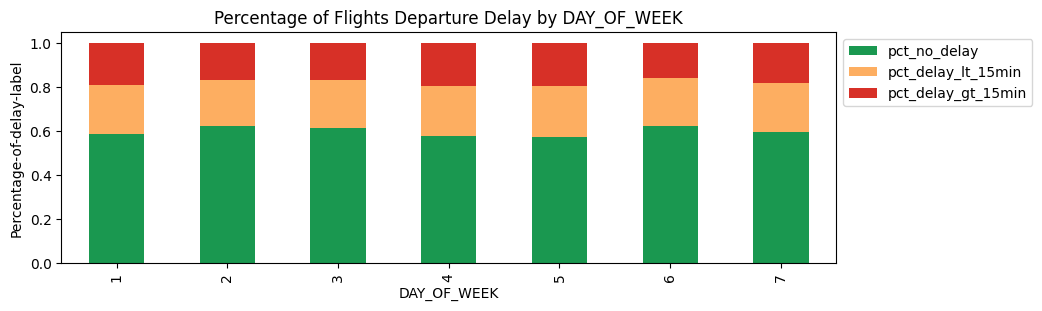

In [0]:
# Day of week - percentage of flights departure delay

input_df = data_col_cleaned
groupby_col = 'DAY_OF_WEEK'
tgt_col = 'DEP_DELAY_GROUP'

md_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True,  figsize=(10,3))

In [0]:
md_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
DAY_OF_WEEK,,,
1,0.587037,0.222277,0.190686
2,0.620083,0.209571,0.170346
3,0.614907,0.214795,0.170298
4,0.575394,0.230052,0.194554
5,0.570448,0.232282,0.197270
6,0.620299,0.217803,0.161899
7,0.596568,0.222903,0.180529


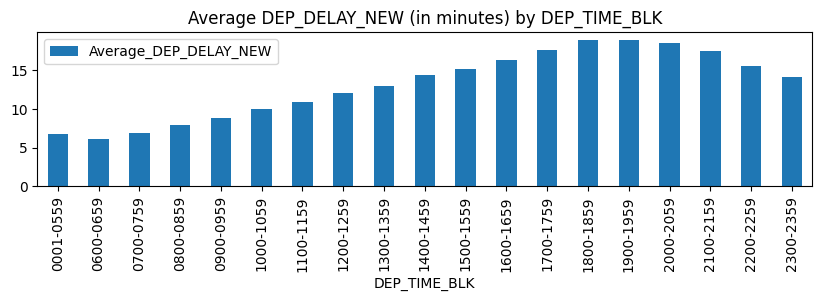

In [0]:
# Departure time
# dep_time_delay_pd = (data_col_cleaned.groupby(['DEP_TIME_BLK']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# dep_time_delay_pd = dep_time_delay_pd.set_index('DEP_TIME_BLK').sort_index()

# # plt.figure(figsize=(10,2))
# dep_time_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Departure Time')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'DEP_TIME_BLK'
tgt_num_col = 'DEP_DELAY_NEW'
dep_time_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

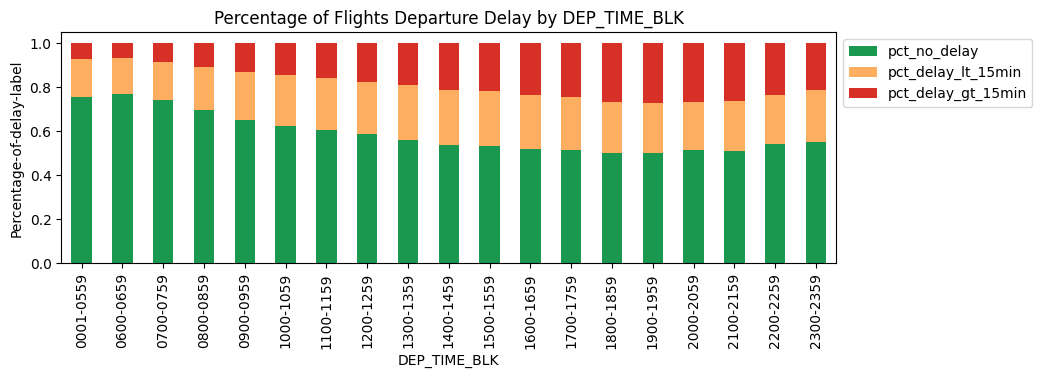

In [0]:
# Departure time - percentage of flights departure delay

input_df = data_col_cleaned
groupby_col = 'DEP_TIME_BLK'
tgt_col = 'DEP_DELAY_GROUP'

dep_time_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True,  figsize=(10,3))

In [0]:
dep_time_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
DEP_TIME_BLK,,,
0001-0559,0.756226,0.171120,0.072653
0600-0659,0.771370,0.163309,0.065320
0700-0759,0.741146,0.172353,0.086501
0800-0859,0.698479,0.194702,0.106818
0900-0959,0.653133,0.218306,0.128561
1000-1059,0.625870,0.227832,0.146298
1100-1159,0.606116,0.233657,0.160226
1200-1259,0.588447,0.236404,0.175149
1300-1359,0.559513,0.250122,0.190365


Comments: we noted apparent hump shape pattern in the average departure delay time by departure time. More specifically the average delay time builds up gradually from mid-night to evening, then tapers off from there. 

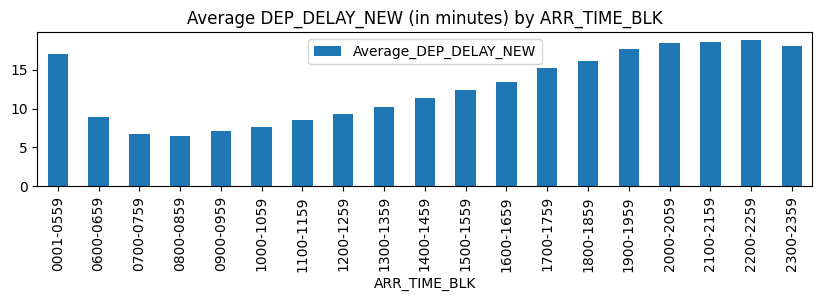

In [0]:
# Arrival time
# arr_time_delay_pd = (data_col_cleaned.groupby(['ARR_TIME_BLK']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# arr_time_delay_pd = arr_time_delay_pd.set_index('ARR_TIME_BLK').sort_index()

# # plt.figure(figsize=(10,2))
# arr_time_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Arrival Time')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'ARR_TIME_BLK'
tgt_num_col = 'DEP_DELAY_NEW'
arr_time_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=True, figsize=(10,2))

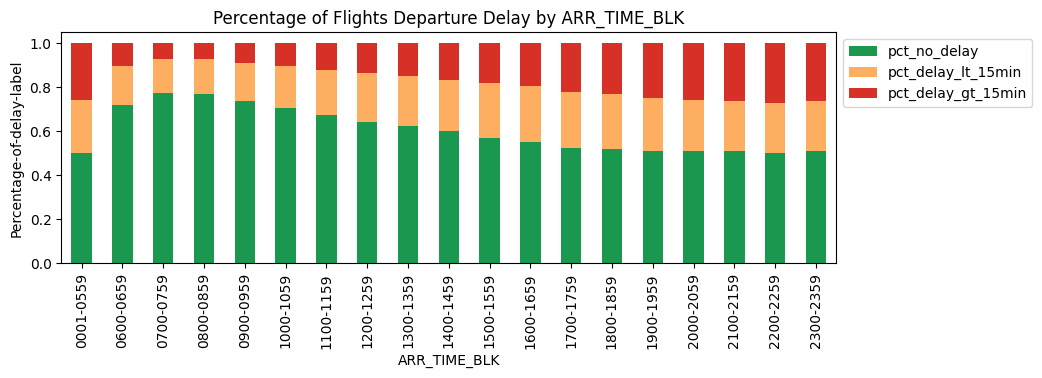

In [0]:
# Arrival time - percentage of flights departure delay

input_df = data_col_cleaned
groupby_col = 'ARR_TIME_BLK'
tgt_col = 'DEP_DELAY_GROUP'

arr_time_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True,  figsize=(10,3))

In [0]:
arr_time_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
ARR_TIME_BLK,,,
0001-0559,0.499371,0.240659,0.259970
0600-0659,0.720317,0.174867,0.104815
0700-0759,0.773552,0.156767,0.069681
0800-0859,0.770210,0.156198,0.073592
0900-0959,0.738581,0.172765,0.088654
1000-1059,0.707559,0.188339,0.104102
1100-1159,0.671841,0.207237,0.120922
1200-1259,0.643022,0.221543,0.135435
1300-1359,0.622237,0.228584,0.149179


Comments: similar to the pattern associated with departure time, we see clear curvy pattern in the average departure delay time by arrival time bucket. Maybe related to the departure time pattern, the hump or peack of this curve shifts towards the later part of the day overall. 

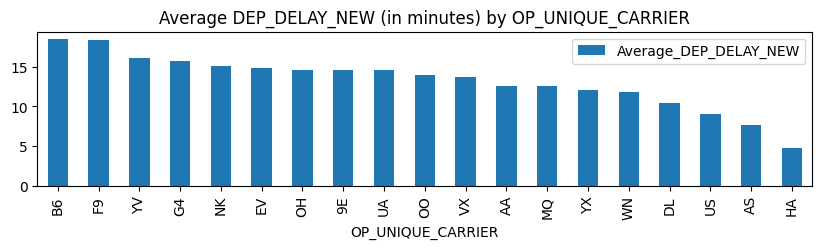

In [0]:
# Carrier
# ca_delay_pd = (data_col_cleaned.groupby(['OP_UNIQUE_CARRIER']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# ca_delay_pd = ca_delay_pd.set_index('OP_UNIQUE_CARRIER').sort_values(by='Average_departure_delay', ascending=False)

# # plt.figure(figsize=(10,2))
# ca_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Unique Carriers')
# # plt.xticks(rotation=45)
# plt.show()

input_df = data_col_cleaned
groupby_col = 'OP_UNIQUE_CARRIER'
tgt_num_col = 'DEP_DELAY_NEW'
ca_delay_pd = get_avg_tgt_num_by_cat_feature(input_df, groupby_col, tgt_num_col, sort_index=False, sort_values=True, ascending=False, figsize=(10,2))

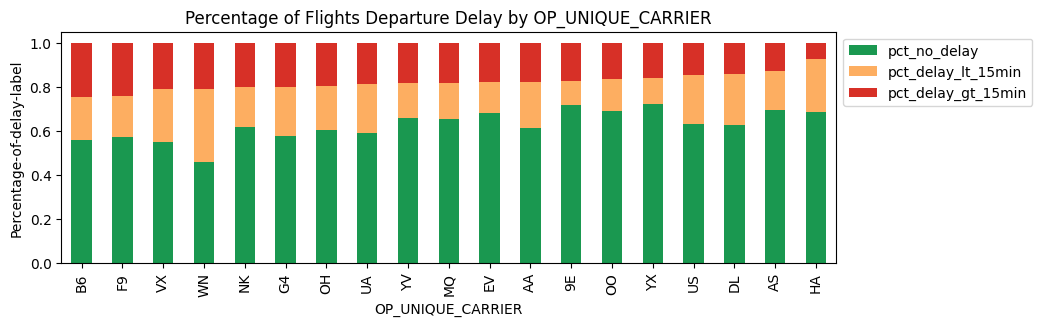

In [0]:
# Carrier - percentage of flights departure delay
input_df = data_col_cleaned
groupby_col = 'OP_UNIQUE_CARRIER'
tgt_col = 'DEP_DELAY_GROUP'

ca_delay_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=False, sort_values=True, ascending=False, figsize=(10,3))

In [0]:
ca_delay_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
OP_UNIQUE_CARRIER,,,
B6,0.558959,0.191617,0.249424
F9,0.572020,0.184166,0.243814
VX,0.549729,0.237656,0.212615
WN,0.458086,0.331359,0.210554
NK,0.614455,0.182629,0.202916
G4,0.573886,0.223885,0.202229
OH,0.604097,0.199501,0.196402
UA,0.589441,0.220303,0.190256
YV,0.659236,0.156300,0.184463


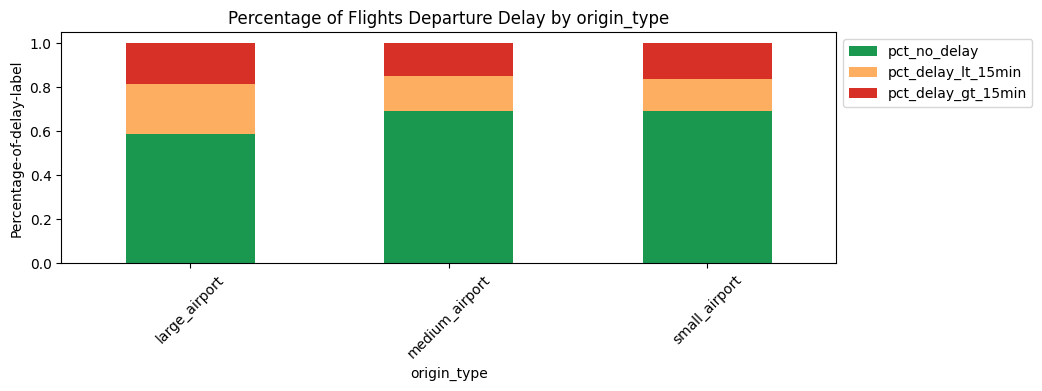

In [0]:
# Origin type
input_df = data_col_cleaned
groupby_col = 'origin_type'
tgt_col = 'DEP_DELAY_GROUP'

origin_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True, sort_values=True, ascending=False, figsize=(10,3),
                                                        xticker_rotate=True)

In [0]:
origin_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
origin_type,,,
large_airport,0.588813,0.226847,0.184340
medium_airport,0.690409,0.161895,0.147696
small_airport,0.690219,0.149165,0.160617


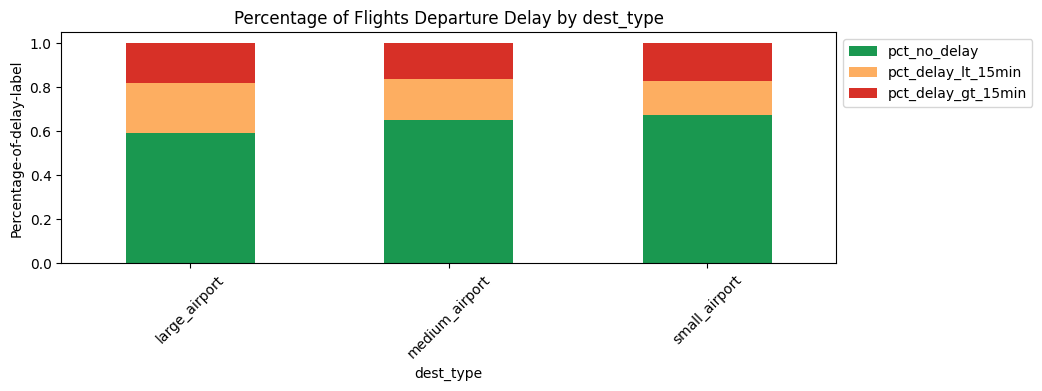

In [0]:
# Arrival type
input_df = data_col_cleaned
groupby_col = 'dest_type'
tgt_col = 'DEP_DELAY_GROUP'

dest_lb_pct_pd = get_tgt_label_pct_by_cat_feature(input_df, groupby_col, tgt_col, sort_index=True, sort_values=True, ascending=False, figsize=(10,3),
                                                        xticker_rotate=True)

In [0]:
dest_lb_pct_pd

,pct_no_delay,pct_delay_lt_15min,pct_delay_gt_15min
dest_type,,,
large_airport,0.592110,0.224995,0.182895
medium_airport,0.652237,0.183449,0.164313
small_airport,0.671997,0.156664,0.171338


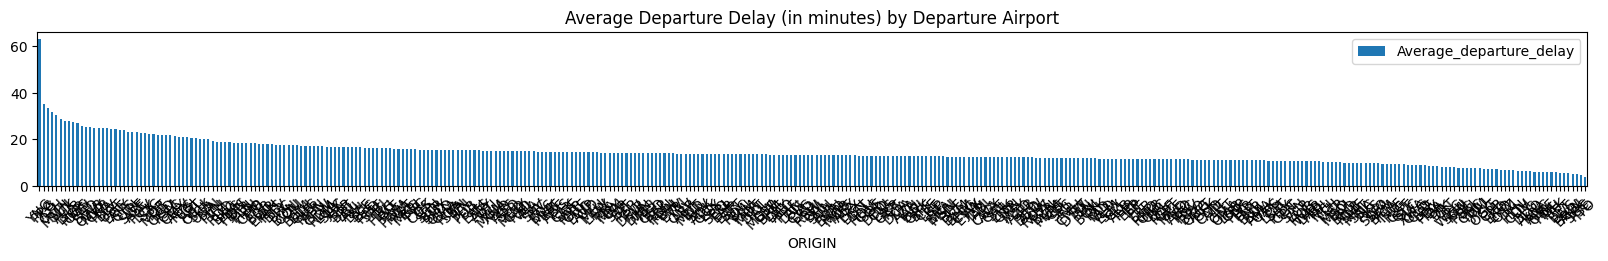

In [0]:
# Departure airport
orig_delay_pd = (data_col_cleaned.groupby(['ORIGIN']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
orig_delay_pd = orig_delay_pd.set_index('ORIGIN').sort_index().sort_values(by='Average_departure_delay', ascending=False)

# plt.figure(figsize=(10,2))
orig_delay_pd.plot(kind='bar', figsize=(20, 2))
plt.title('Average Departure Delay (in minutes) by Departure Airport')
plt.xticks(rotation=45)
plt.show()


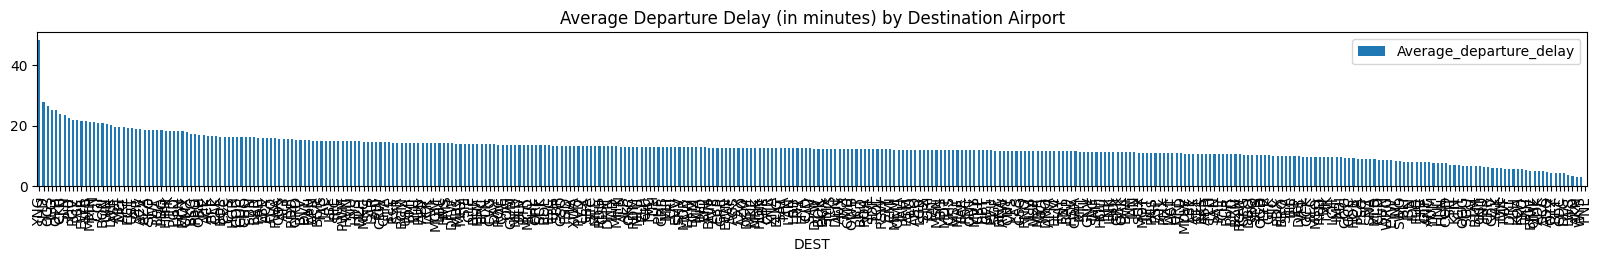

In [0]:
# Destination airport
des_delay_pd = (data_col_cleaned.groupby(['DEST']).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
des_delay_pd = des_delay_pd.set_index('DEST').sort_index().sort_values(by='Average_departure_delay',ascending=False)

# plt.figure(figsize=(10,2))
des_delay_pd.plot(kind='bar', figsize=(20, 2))
plt.title('Average Departure Delay (in minutes) by Destination Airport')
# plt.xticks(rotation=45)
plt.show()

In [0]:
# # Latitude of departure airport
# dep_lat_delay_pd = (data_col_cleaned.groupby(F.floor('origin_airport_lat').alias('origin_lat_blk')
#                                                  ).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# dep_lat_delay_pd = dep_lat_delay_pd.set_index('origin_lat_blk').sort_index()

# # plt.figure(figsize=(10,2))
# dep_lat_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Departure Airport Latitude')
# # plt.xticks(rotation=45)
# plt.show()

Comments: we can see meaningful differences in average delay time by different bucket of original departure airport longitude.

In [0]:
# # Latitude of destination airport
# dest_lat_delay_pd = (data_col_cleaned.groupby(F.floor('dest_airport_lat').alias('dest_lat_blk')
#                                                  ).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# dest_lat_delay_pd = dest_lat_delay_pd.set_index('dest_lat_blk').sort_index()

# # plt.figure(figsize=(10,2))
# dest_lat_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Destination Airport Latitude')
# # plt.xticks(rotation=45)
# plt.show()


Comments: we can see meaningful differences in average delay time by different bucket of original departure airport longitude.

In [0]:
# # Latitude of destination airport
# dest_lat_delay_pd = (data_col_cleaned.groupby(F.floor('dest_airport_lat').alias('dest_lat_blk')
#                                                  ).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# dest_lat_delay_pd = dest_lat_delay_pd.set_index('dest_lat_blk').sort_index()

# # plt.figure(figsize=(10,2))
# dest_lat_delay_pd.plot(kind='bar', figsize=(10, 2))
# plt.title('Average Departure Delay (in minutes) by Destination Airport Latitude')
# # plt.xticks(rotation=45)
# plt.show()

Comments: we can see meaningful differences in average delay time by different bucket of destination departure airport longitude.

In [0]:
# # Longitude of destination airport
# dest_long_delay_pd = (data_col_cleaned.groupby(F.floor('dest_airport_lon').alias('dest_lon_blk')
#                                                  ).agg(F.avg('DEP_DELAY_NEW').alias('Average_departure_delay'))).toPandas()
# dest_long_delay_pd = dest_long_delay_pd.set_index('dest_lon_blk').sort_index()

# # plt.figure(figsize=(10,2))
# dest_long_delay_pd.plot(kind='bar', figsize=(14, 2))
# plt.title('Average Departure Delay (in minutes) by Destination Airport Longitude')
# # plt.xticks(rotation=45)
# plt.show()

Comments: we can see meaningful differences in average delay time by different bucket of original destination airport longitude.

In [0]:
## Check pearson correlation
